In [2]:
#This notebook will try to detect the gender information from ML model. Sklearn.
import pandas as pd
import json
import re
import unicodedata

In [25]:
cols = ["gender","raw_text"]
df = pd.read_csv("./(V1.8)all_products_data_set.csv", usecols=cols)

In [133]:
count = 0
type = set()

for row in range(df.shape[0]):
    gender_words = df.loc[row]['gender']
    if gender_words == 'women\xa0':
        df.loc[row, 'gender'] = gender_words.replace(u'\xa0', u'')
        count+=1
    if gender_words == 'men\xa0':
        df.loc[row, 'gender'] = gender_words.replace(u'\xa0', u'')
        count += 1
print(count)
df.shape

0


(28426, 2)

In [26]:
df = df[pd.notnull(df['raw_text'])]
df = df[pd.notnull(df['gender'])]
df.shape

(25985, 2)

In [27]:
col = ["gender", "raw_text"]
#modify names of columns
df.columns = ["Gender", "Product_Description"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25985 entries, 0 to 28425
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               25985 non-null  object
 1   Product_Description  25985 non-null  object
dtypes: object(2)
memory usage: 609.0+ KB


In [28]:
#drop the unknown/unset/broken
index_broken = df[((df.Gender == "broken") | (df.Gender == "unknown") | (df.Gender == "unset") |(df.Gender == "unisex/unknown"))].index
df = df.drop(index_broken)
df.shape

(24521, 2)

In [29]:
df['gender_id'] = df['Gender'].factorize()[0]
from io import StringIO
category_id_df = df[['Gender', 'gender_id']].drop_duplicates().sort_values('gender_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['gender_id', 'Gender']].values)
df.head()

,Gender,Product_Description,gender_id
0,women,The Sol. These bottoms are made from 100% recy...,0
1,women,These Bitsy Roger bottoms are crafted from shi...,0
2,women,Nothing says high and mighty like the Frenchi ...,0
3,women,The Desi Bottoms is made from 100% recycled ma...,0
4,women,Meet Court. Your new summer BFF. These high wa...,0


In [30]:
category_to_id

{'women': 0, 'na': 1, 'unisex': 2, 'men': 3, 'girls': 4, 'boys': 5}

In [31]:
id_to_category

{0: 'women', 1: 'na', 2: 'unisex', 3: 'men', 4: 'girls', 5: 'boys'}

In [27]:
#df = df.query('(Gender == "women")').sample(n=2000)

In [32]:
#modify the bias
temp_df = df.query('(Gender == "men")').sample(n=4000)
index_men = df[(df.Gender == "men")].index
df = df.drop(index_men)

df = df.append(temp_df)

temp_df = df.query('(Gender == "women")').sample(n=4000)
index_women = df[(df.Gender == "women")].index

df = df.drop(index_women)
df = df.append(temp_df)


/var/folders/r2/xt2ymfnd7nz2khk687zqlrpr0000gn/T/ipykernel_85455/797606053.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/r2/xt2ymfnd7nz2khk687zqlrpr0000gn/T/ipykernel_85455/797606053.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)


In [33]:
df = df.sort_index()

In [34]:
df.head()

,Gender,Product_Description,gender_id
0,women,The Sol. These bottoms are made from 100% recy...,0
5,women,A retro-inspired sculptural silhouette makes t...,0
7,women,The Maggie Top is all things feminine With a s...,0
8,na,"A gentle, wild crafted dandelion and elderflow...",1
9,women,Hello Jess! Made from 100% recycled materials....,0


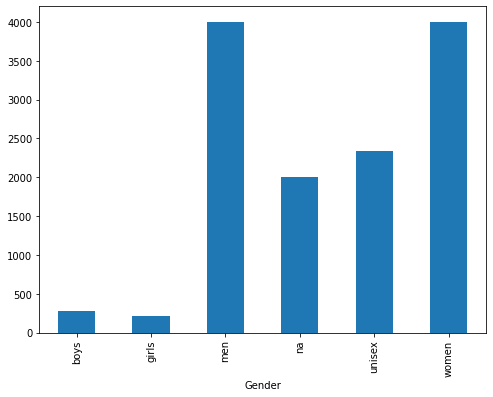

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Gender').Product_Description.count().plot.bar(ylim=0)
plt.show()

#### need to take the number of 'men' and 'women' to around 3000, otherwise it will cause the bias of the data.

In [36]:
df.columns

Index(['Gender', 'Product_Description', 'gender_id'], dtype='object')

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Product_Description).toarray()
labels = df.gender_id
features.shape

(12845, 34653)

In [39]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Gender, gender_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == gender_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Gender))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'boys':
  . Most correlated unigrams:
       . boy
       . boys
  . Most correlated bigrams:
       . boys black
       . shirt boys
# 'girls':
  . Most correlated unigrams:
       . kids
       . girls
  . Most correlated bigrams:
       . supply kids
       . years age
# 'men':
  . Most correlated unigrams:
       . men
       . shirt
  . Most correlated bigrams:
       . 100 cotton
       . shirt black
# 'na':
  . Most correlated unigrams:
       . includes
       . sheet
  . Most correlated bigrams:
       . black grip
       . sheet black
# 'unisex':
  . Most correlated unigrams:
       . ones
       . sticker
  . Most correlated bigrams:
       . larger kids
       . 10 12
# 'women':
  . Most correlated unigrams:
       . bust
       . neckline
  . Most correlated bigrams:
       . sky fit
       . fit guide


In [40]:
#Separate the test and train data set
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Product_Description'], df['Gender'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [41]:
print(clf.predict(count_vect.transform(["This blue v neck jacket is sweet and beautiful and cute"])))

['women']


In [42]:
print(clf.predict(count_vect.transform(["This is male jacket and so cool."])))

['men']


In [43]:
print(clf.predict(count_vect.transform(["Baby strawberry girls' t-shirt is so perfect for age under 12."])))

['women']


In [44]:
print(clf.predict(count_vect.transform(["Boys' big toy."])))

['men']


In [45]:
#test couple more models and see their performance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [47]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.653795
LogisticRegression        0.632308
MultinomialNB             0.612845
RandomForestClassifier    0.422343
Name: accuracy, dtype: float64

In [48]:
#make sure the index is continuous
df = df.reset_index()

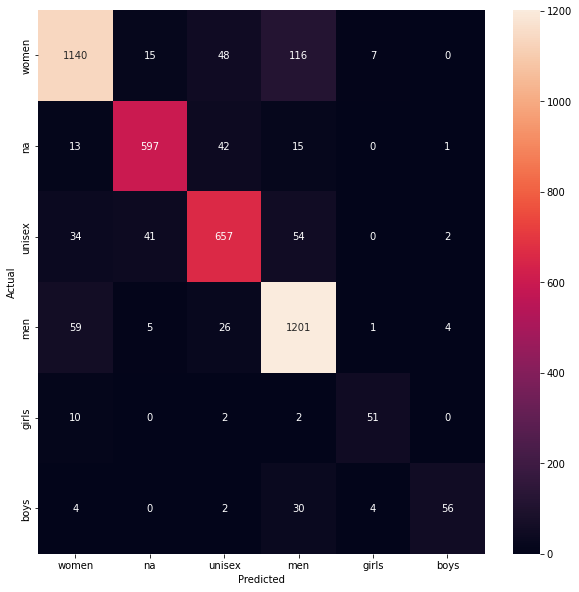

In [49]:
import seaborn as sns
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Gender.values, yticklabels=category_id_df.Gender.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [50]:
from IPython.display import display
for predicted in category_id_df.gender_id:
  for actual in category_id_df.gender_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Gender', 'Product_Description']])
      print('')

'na' predicted as 'women' : 13 examples.


,Gender,Product_Description
7996,na,The Stuntwood is a straightforward freestyle b...
10390,na,Louis Vuitton leather lighter wrap made from g...
799,na,To add depth to a coffee table or texture to a...
12126,na,Additional Information: PLU: 31827
2007,na,15 Minute Maximum | Lay-Down Bed with 2 Facial...
10532,na,"Bloomingville is the epitome of Nordic design,..."
2228,na,This sling bag can sit at the waist or around ...
12459,na,Additional Information: It is summer year roun...
800,na,"Ideal for small storage, the bowl basket is ha..."
9343,na,Our Texturizing Sea Spray protects your hair f...



'unisex' predicted as 'women' : 34 examples.


,Gender,Product_Description
11116,unisex,This is one of the most powerful grounding and...
313,unisex,Unisex sweatshirt with an easy relaxed fit. De...
10468,unisex,Messenger Bag 26 × 32 × 8 cm Compartments: Mai...
10996,unisex,Backpack is a true Rains classic made from a w...
11053,unisex,Description: Wed like to introduce you to one ...
10621,unisex,The 18K Dripps Box Cross Necklace is an adjust...
10689,unisex,"These petite, lightweight links lay flat again..."
752,unisex,"A symbol of resilience, passion and self-aware..."
12206,unisex,Additional Information: The most fun you’ve ha...
188,unisex,High rise carpenter-inspired denim pant with m...



'men' predicted as 'women' : 59 examples.


,Gender,Product_Description
3008,men,U550060M-BLK A warm weather singlet that combi...
2495,men,1123163-BDBB Soft. Smooth. Bliss. Earning its ...
2406,men,287641-1940 Long-time award winner and best se...
1872,men,ONeill is New Blueprint Series continues our l...
5555,men,Description and Details Armani Exchange AX2145...
1753,men,AL0A547L020 The legend continues with the newe...
4734,men,The Ex-Boyfriend jean is a slouchy slim style ...
1261,men,"Knit poncho featuring, perfect to throw on ove..."
10332,men,100% cotton Two U-shaped hip pockets Ribbed cu...
8662,men,LOOK NATURAL IN THE PTC ROLL IT T-SHIRT. THIS ...



'girls' predicted as 'women' : 10 examples.


,Gender,Product_Description
12623,girls,Additional Information: This teeny two-piece s...
6972,girls,Rompers are in and she will be too with this t...
10484,girls,The Wavechaser Zippy Rash Guard is a UV swim s...
11739,girls,Hatley kids cable knit tights Elastic waistban...
11650,girls,Hatley kids fluffy pom poms headband Fun and q...
9720,girls,Description The Knew Wave Hoodie is a boxy pul...
735,girls,"Straight leg, slim fit indigo jean with detail..."
12707,girls,Additional Information: This swimsuit features...
11617,girls,Hatley kids metallic snowflakes holiday tulle ...
9814,girls,"A little surfy and a little sweet, a floral pr..."



'women' predicted as 'na' : 15 examples.


,Gender,Product_Description
4000,women,Artisan work of a mountain tribe in China. The...
12224,women,Our custom designed Mamas for Mamas Towel is m...
12233,women,Our custom designed Retro Curve Towel is made ...
8733,women,Jones Nomad Climbing Skins are premium splitbo...
733,women,The coconut oil and aluminum FREE baking soda ...
10840,women,WRITE YOUR HEART OUT and capture your hopes an...
11386,women,Most Useful Necklace Ever! Attach your mask in...
12345,women,Our unisex Nordic Robe is made from super soft...
9619,women,Thrash every side hit in sight with the Burton...
2033,women,Beards need love too . . am I right? Our high ...



'unisex' predicted as 'na' : 41 examples.


,Gender,Product_Description
2805,unisex,NS8000-0586-00 WHY YOULL LOVE IT Safety first!...
4919,unisex,"To catch a good game, head north. Since making..."
397,unisex,"A bold pattern in a versatile, neutral colour-..."
9430,unisex,The Surf Glass 27 in colour Blaze comes in siz...
9190,unisex,Our Nineballs have been a long-time favorite o...
6945,unisex,Pro-tec set the industry standard when the Str...
2031,unisex,NEW SEASONAL SCENT Pumpkin + Cinnamon + Vanill...
7076,unisex,63mm Doozies. Wide than the fatties so you get...
2917,unisex,7530426-104 Prevent the uncomfortable feeling ...
2153,unisex,Raise a glass (or two) to the coolest stemless...



'women' predicted as 'unisex' : 48 examples.


,Gender,Product_Description
4901,women,"Made for all day, every day. Offering clean li..."
11153,women,The heart is a universal symbol for love in al...
11611,women,Okanagan Lifestyle OKGN fleece tee This brand ...
499,women,Impossibly soft. Wear it all day and then roll...
4643,women,A classic carry-in-your wallet gift card that ...
11047,women,Description: A stylish + cozy fit made for the...
12443,women,Additional Information: A cold weather essenti...
5619,women,Details Go retro. The perfect late 80s vibe me...
10519,women,Use: Performance Notes: Our core high-waisted ...
3213,women,Description: Handmade Canadian leather wallet ...



'na' predicted as 'unisex' : 42 examples.


,Gender,Product_Description
1845,na,Our Daily Revitalizing Shampoo helps deliver d...
1842,na,"It’s just like an umbrella, only better. Stay ..."
8692,na,"Plane, train, or automobile. Take the puzzle o..."
2164,na,Sun Bum wanted to make sure they have got you ...
5389,na,Big enough for a whole day on the river or tra...
12312,na,"Additional Information: Shape, soften, and nou..."
532,na,Lavender and Frankincense is a calming and rel...
10632,na,"14L x 6W Cotton Wine Bag w/ Saying, 6 Styles"
2175,na,S24SX454 Drink in the adventure. A little more...
8490,na,"Affordable, easy skating mini cruzer with supe..."



'men' predicted as 'unisex' : 26 examples.


,Gender,Product_Description
5124,men,This bag’s casual styling and deceptively clev...
8600,men,Cover your tracks in style with these OTC sock...
5125,men,A little sidekick you’ll forget you’re wearing...
5094,men,Blending retro sport styling with truly modern...
10896,men,We designed this classic signet ring to make y...
5333,men,Details: When extraordinary vision relies on p...
5168,men,Outside Magazine has named Dirty Mo 2 winner o...
9363,men,The Arcade Rambler Adventure belt is lightweig...
10363,men,Versatile 1inch wide belt made with 4mm thick ...
5842,men,The big brother of Finn. Overall dimension: ab...



'women' predicted as 'men' : 116 examples.


,Gender,Product_Description
10746,women,Rubber boots with a stylish ‘biker’ twist from...
1943,women,Hand polished polycarbonate frames ● Premium s...
8016,women,It’s all in the details. This asymmetrical swe...
4336,women,"A minimalist take on vintage workwear, the Cha..."
9416,women,Make warm hands your priority with these insul...
...,...,...
2606,women,"22795-NAT Influenced by our fleece heritage, b..."
8119,women,"The legendary control, versatility, and comfor..."
12584,women,Additional Information: CYPRESS HILL BLACK SUN...
2639,women,L41457900 The WILDCROSS 2 GORE-TEX is made for...



'na' predicted as 'men' : 15 examples.


,Gender,Product_Description
640,na,Clarity. Bloom. Vibrant. Just like a bouquet o...
7146,na,AIRHOLE McCallister Standard I Series
9643,na,Signature striped fabric liner detail Padded a...
9205,na,A tribute to the Okanagan Lake Monster. Made i...
9944,na,The Juvie boot is designed for young riders se...
776,na,This simple and beautiful c anvas pouch is han...
9206,na,A tribute to the Okanagan Lake Monster. Made i...
10857,na,Barbara Scott-Goodman Wine Bites is an inspiri...
639,na,Serene. Summer. Calm. Wild roses only bloom br...
2179,na,"Miami mama, Ibiza babe, Cancun cutie – No matt..."



'unisex' predicted as 'men' : 54 examples.


,Gender,Product_Description
7946,unisex,The 187 junior pads are the industry best for ...
5244,unisex,"Made with smooth leather, the Charlie Leather ..."
10313,unisex,Men is Athletic Water Resistant Pant Hybrid pa...
10374,unisex,Brand new dark indigo blue raw denim Dickie Ov...
10397,unisex,Up-cycled from the quilted raw denim and chino...
7072,unisex,"The ultimate in carving and comfort, the Battl..."
12811,unisex,"Finally, a fitness tee that’s built to outlast..."
10503,unisex,Our Beta Packable Bucket Hat always bounces ba...
5218,unisex,This guy is made for you. Whether you take him...
14,unisex,Teleport back to the 70 is with BandP is Bottl...



'boys' predicted as 'men' : 30 examples.


,Gender,Product_Description
10723,boys,Slouch fit Cotton/Linen blend Vintage black te...
9403,boys,"A staple for the beach, backyard, and everythi..."
10057,boys,You will love how the Frickin Slim Jogger take...
9978,boys,These Vorta 5 Pocket Slub Jean is crafted with...
8776,boys,"For breathable warmth that blocks the chill, t..."
6116,boys,The Primary Volley II is a cotton nylon volley...
6541,boys,The Boys Drop V Bucket Hat is made with 60% co...
9859,boys,"YOUR ONE AND DONE SHORT, RVCA BOYS ALL TIME CO..."
8078,boys,Nothing beats the comfort and versatility of a...
6672,boys,The Boys Dual Palm Sun Shirt is a 100% polyest...


In [51]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'boys':
  . Top unigrams:
       . boys
       . boy
  . Top bigrams:
       . shirt youth
       . dex kids
# 'girls':
  . Top unigrams:
       . girls
       . kids
  . Top bigrams:
       . hatley kids
       . piece new
# 'men':
  . Top unigrams:
       . men
       . mens
  . Top bigrams:
       . cotton colour
       . size large
# 'na':
  . Top unigrams:
       . skateboard
       . towel
  . Top bigrams:
       . sheet black
       . rds lanyard
# 'unisex':
  . Top unigrams:
       . unisex
       . sticker
  . Top bigrams:
       . trucker hats
       . hats colour
# 'women':
  . Top unigrams:
       . women
       . womens
  . Top bigrams:
       . okanagan lifestyle
       . high rise


In [52]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Gender'].unique()))

              precision    recall  f1-score   support

       women       0.90      0.86      0.88      1326
          na       0.91      0.89      0.90       668
      unisex       0.85      0.83      0.84       788
         men       0.85      0.93      0.89      1296
       girls       0.81      0.78      0.80        65
        boys       0.89      0.58      0.70        96

    accuracy                           0.87      4239
   macro avg       0.87      0.81      0.83      4239
weighted avg       0.87      0.87      0.87      4239



In [209]:
texts = ["This blue v neck jacket is sweet and beautiful and cute.",
         "This is male jacket and so cool",
         "Baby strawberry girls' t-shirt is so perfect for age under 12.",
         "A little baby's funny toy.",
         "This sunglasses will be good for male and female",
         "Big teen would like this cool jean",
         "hello world",
         "Style Deals - When temps start to rise, slip into this supremely cute babydoll dress outfitted with a vibrant floral print! Its warm-weather details include short sleeves, round neckline, and a slightly shorter length. Team this with your sandals, straw hat, and of course, your oversized sunnies."
         ]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"This blue v neck jacket is sweet and beautiful and cute."
  - Predicted as: 'women'

"This is male jacket and so cool"
  - Predicted as: 'men'

"Baby strawberry girls' t-shirt is so perfect for age under 12."
  - Predicted as: 'girls'

"A little baby's funny toy."
  - Predicted as: 'unisex'

"This sunglasses will be good for male and female"
  - Predicted as: 'unisex/unknown'

"Big teen would like this cool jean"
  - Predicted as: 'men'

"hello world"
  - Predicted as: 'unisex'

"Style Deals - When temps start to rise, slip into this supremely cute babydoll dress outfitted with a vibrant floral print! Its warm-weather details include short sleeves, round neckline, and a slightly shorter length. Team this with your sandals, straw hat, and of course, your oversized sunnies."
  - Predicted as: 'women'



In [172]:
import pickle
#save model
with open('gender_detector_model.pkl', 'wb') as f:
    pickle.dump(model,f)

#load model
with open("gender_detector_model.pkl", 'rb') as f:
    loaded_gender_detect_model = pickle.load(f)

#save the vectorizer
pickle.dump(tfidf, open("vectorizer.pkl", "wb"))
    

In [190]:
import spacy
stat = spacy.load("./output/model-best/")
rule = spacy.load("./output_rule_based_model/")


In [204]:
d1 = stat("This men's snake and leopard jacket is size XL")
d2 = rule("This blue men's jacket is size XL.liberty Snake pattern style pattern")
s1 = set()
s2 = set()
for ent in d1.ents:
    s1.add((ent, ent.label_))
for ent in d2.ents:
    s2.add((ent, ent.label_))
print(s1)
print(s2)


{(snake, 'PATTERN'), (men, 'GENDER'), (XL, 'SIZE'), (leopard, 'PATTERN'), (jacket, 'TOPS')}
{(jacket, 'TOPS'), (men, 'GENDER'), (blue, 'COLOR'), (Snake, 'PATTERN')}


In [ ]:
()